In [221]:
import numpy as np
import exoplanet as xo
import matplotlib.pyplot as pl
import utils
import itertools
import theano
from theano import tensor as tt

red = '#FE4365'
blue = '#00A9FF'
yellow = '#ECA25C'
green = '#3F9778'
darkblue = '#005D7F'

pl.rc('xtick', labelsize=20)
pl.rc('ytick', labelsize=20)
pl.rc('axes', labelsize=25)
pl.rc('axes', titlesize=30)
pl.rc('legend', fontsize=20)
pl.rc('lines', linewidth=4)

# function to compute the un-inverted Fisher information matrix 
def fullfisher(t, tparams, gpparams, a=[1]):
    a = np.array(a)
    log_s, log_w0, log_q, diag = gpparams
    Q = a[:, None]*a[None, :]
    
    # define the gp 
    term = xo.gp.terms.SHOTerm(log_S0=log_s, log_w0=log_w0, log_Q=log_q)
    kernel = xo.gp.terms.KroneckerTerm(term, Q)
    diag = diag * np.ones((len(a), len(t)))
    gp = xo.gp.GP(kernel=kernel, diag=diag, x=t, J=2*len(a))
    
    # compute the trapezoidal transit derivatives
    dtrans = utils.transit(t, *tparams)
    x = tt.dmatrix()
    y = tt.dmatrix()
    
    # define a theano function to compute the inner product of the pairs of 
    # derivatives with the inverse covariance matrix 
    f = theano.function([x, y], [x.T.dot(gp.apply_inverse_vector(y))])
    
    # compute the Fisher matrix 
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        x = np.tile(x, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(x)).T
        y = np.tile(y, (np.shape(Q)[0], 1)).T.reshape(1, np.shape(Q)[0]*len(y)).T
        fish[i, j] = f(x, y)[0][0, 0]
        
    # return the fisher matrix and the gp for debugging 
    return fish, gp

# function to unpack the individual uncertainties
def fisher(t, tparams, gpparams, a=[1]):
    fish, gp = fullfisher(t, tparams, gpparams, a=a)
    return np.sqrt(np.diag(np.linalg.inv(fish))), gp

# function to compute the fisher information when there 
# is no correlated component to the variability 
def fisher_white_noise_only(t, tparams, diag):
    dtrans = utils.transit(t, *tparams)
    fish = np.zeros((4, 4))
    for (i, j) in itertools.product([0, 1, 2, 3], [0, 1, 2, 3]):
        x = np.array(dtrans[i+1])
        y = np.array(dtrans[j+1])
        fish[i, j] = (1/diag)*x.T.dot(y)
    return np.sqrt(np.diag(np.linalg.inv(fish)))

In [217]:
# alpha_N / alpha_1 
x = np.linspace(1, 10, 10)

# variance of the white noise 
diag = np.exp(-20)

# sqrt(variance) of the correlated component 
alpha = np.exp(-10)

# smallest and largest wavelength scale factors 
alpha1 = 2 / (1 + x)
alpha2 = 2 / (1 + 1/x)

# compute alpha vectors 
a = np.array([alpha1, alpha2]).T
a3 = [np.linspace(a1, a2, 3) for (a1, a2) in zip(alpha1, alpha2)]
a4 = [np.linspace(a1, a2, 4) for (a1, a2) in zip(alpha1, alpha2)]
a5 = [np.linspace(a1, a2, 5) for (a1, a2) in zip(alpha1, alpha2)]

# parameters of the transit and correlated noise 
t = np.linspace(-5, 5, 5000)
tparams = [0.0, 0.1, 1.0, 0.01]  # t0, r, d, tin
logw0 = 5.0
logq = -np.log(np.sqrt(2))

In [204]:
# for visualizing the samples 

#fish2, gp2 = fisher(t, tparams, [np.log(alpha), logw0, logq, diag*2], a=a[5])
#fish3, gp3 = fisher(t, tparams, [np.log(alpha), logw0, logq, diag*3], a=a3[5])
#fish4, gp4 = fisher(t, tparams, [np.log(alpha), logw0, logq, diag*4], a=a4[5])
#fish5, gp5 = fisher(t, tparams, [np.log(alpha), logw0, logq, diag*5], a=a5[5])

In [205]:
# for visualizing the samples 

#y2 = gp2.dot_l(np.random.randn(2*len(t), 1)).eval()
#y3 = gp3.dot_l(np.random.randn(3*len(t), 1)).eval()
#y4 = gp4.dot_l(np.random.randn(4*len(t), 1)).eval()
#y5 = gp5.dot_l(np.random.randn(5*len(t), 1)).eval()

In [187]:
# for visualizing the samples 

#y2 = np.sum([y2[i::2].T[0] for i in range(2)], axis=0)/2
#y3 = np.sum([y3[i::3].T[0] for i in range(3)], axis=0)/3
#y4 = np.sum([y4[i::4].T[0] for i in range(4)], axis=0)/4
#y5 = np.sum([y5[i::5].T[0] for i in range(5)], axis=0)/5

In [222]:
# for visualizing the samples 

#pl.figure(figsize=(20, 5))
#pl.plot(t, y2[1::2], '.')
#pl.plot(t, y2[::2], '.')
#pl.plot(t + 10, y3[2::3], '.')
#pl.plot(t + 10, y3[1::3], '.')
#pl.plot(t + 10, y3[::3], '.')
#pl.plot(t + 20, y4[3::4], '.')
#pl.plot(t + 20, y4[2::4], '.')
#pl.plot(t + 20, y4[1::4], '.')
#pl.plot(t + 20, y4[::4], '.')
#pl.plot(t + 30, y5[4::5], '.')
#pl.plot(t + 30, y5[3::5], '.')
#pl.plot(t + 30, y5[2::5], '.')
#pl.plot(t + 30, y5[1::5], '.')
#pl.plot(t + 30, y5[::5], '.')

In [218]:
# compute the fisher information as a function of x 

fish1 = [fisher_white_noise_only(t, tparams, diag) for a in a]
fish2 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*2], a=a)[0] for a in a]
fish3 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*3], a=a)[0] for a in a3]
fish4 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*4], a=a)[0] for a in a4]
fish5 = [fisher(t, tparams, [np.log(alpha), logw0, logq, diag*5], a=a)[0] for a in a5]

Text(0,0.5,'1-$\\sigma$ uncertainty for $R_p/R_*$')

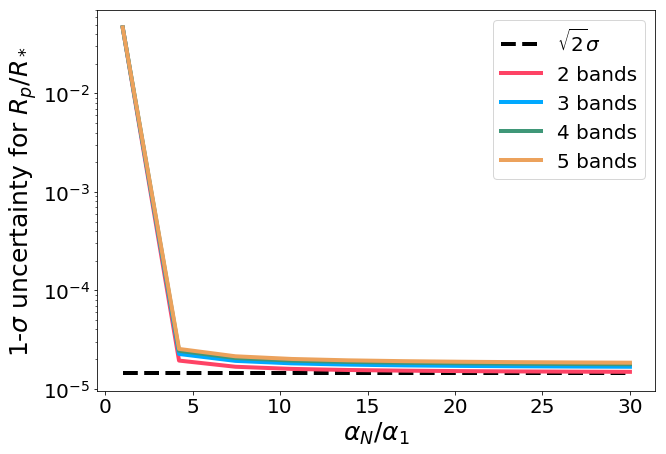

In [223]:
# plot the fisher information as a function of x 

figure = pl.figure(figsize=(10, 7))
pl.semilogy(x, np.sqrt(2)*np.array(fish1)[:, 1], '--', color='k', label=r"$\sqrt{2}\sigma$")
pl.semilogy(x, np.array(fish2)[:, 1], '-', color=red, label="2 bands")
pl.semilogy(x, np.array(fish3)[:, 1], '-', color=blue, label="3 bands")
pl.semilogy(x, np.array(fish4)[:, 1], '-', color=green, label="4 bands")
pl.semilogy(x, np.array(fish5)[:, 1], '-', color=yellow, label="5 bands")

pl.legend()
#pl.ylim(0, 1)
pl.xlabel(r"$\alpha_N/\alpha_1$")
pl.ylabel(r"1-$\sigma$ uncertainty for $R_p/R_*$")